# Задание

Необходимо провести оценку временного ряда, идентифицировать аномальные и пропущенные значения, заменить их предыдущим. (Реализация методом IQR, не использовать готовые функции, типа scipy.stats.iqr).

# Решение

## Inputs

In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.model_selection import train_test_split

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

from sklearn.model_selection import GridSearchCV

## Functions

In [380]:
def drow_subplot_wells(df: pd.DataFrame, columns = [], type = 'plot',  figsize = (25, 20)):
    fig, axs = plt.subplots(3, 2, figsize = figsize)

    for i, well in enumerate(df.WELL_ID.unique()):
        col = (i+1) // 4 
        row = i - 3 * col

        df_sample = pd.DataFrame(
            data = df.loc[df.WELL_ID == well][columns]
        )

        df_sample.DATES = pd.to_datetime(
            df_sample['DATES'],
            dayfirst= True,
            yearfirst= False,
        )

        df_sample = df_sample.set_index('DATES')
        df_sample = df_sample.sort_index()

        if type == 'plot':
            axs[row, col].plot(
                df_sample
            )
            axs[row, col].set_xlabel('DATES')
            axs[row, col].set_ylabel(columns[-1])
        
        elif type == 'hist':
            axs[row, col].hist(
                df_sample
            )
            axs[row, col].set_ylabel(columns[-1])

        elif type == 'boxplot':
            axs[row, col].boxplot(
                df_sample,
                vert=False
            )
            axs[row, col].set_xlabel(columns[-1])

        axs[row, col].set_title('Well '+str(well))
        
    plt.show()

## Main

### Читаем датасет

In [381]:
df = pd.read_csv('./data1.csv')
df

,WELL_ID,DATES,PCOL_TM,PBUF_TM,PZAT_TM,PLIN_TM
0,110009100,17.2.2022 2:42:59,9.25,8.36,8.74,NaN
1,110009100,17.2.2022 2:44:00,8.43,8.38,8.74,NaN
2,110009100,17.2.2022 2:50:00,8.32,8.36,8.53,NaN
3,110009100,17.2.2022 2:55:00,8.34,8.38,8.56,NaN
4,110009100,17.2.2022 3:36:59,8.39,8.38,8.67,NaN
...,...,...,...,...,...,...
40389,110302100,12.2.2022 17:32:00,8.21,18.96,10.48,NaN
40390,110302100,12.2.2022 17:42:00,8.52,18.96,10.48,NaN
40391,110302100,12.2.2022 18:06:59,8.24,18.95,10.45,NaN
40392,110302100,12.2.2022 18:08:59,8.22,18.97,10.47,NaN


### Первичная информация

In [382]:
display(df.describe())
display(df.info())

,WELL_ID,PCOL_TM,PBUF_TM,PZAT_TM,PLIN_TM
count,4.039400e+04,40034.000000,40375.000000,40375.000000,19664.000000
mean,1.100944e+08,12.729014,15.863011,14.806302,17.299327
std,1.058889e+05,4.692983,4.529167,5.061554,2.048875
min,1.100091e+08,7.900000,8.320000,8.280000,8.230000
25%,1.100125e+08,8.330000,11.810000,10.385000,17.610000
50%,1.100438e+08,8.620000,17.200000,11.400000,17.770000
75%,1.101438e+08,17.750000,19.770000,20.530000,17.920000
max,1.103021e+08,18.560000,22.620000,22.170000,19.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40394 entries, 0 to 40393
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  40394 non-null  int64  
 1   DATES    40394 non-null  object 
 2   PCOL_TM  40034 non-null  float64
 3   PBUF_TM  40375 non-null  float64
 4   PZAT_TM  40375 non-null  float64
 5   PLIN_TM  19664 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


None

### Уникальные значения по столбцам

In [383]:
for col in df.columns:
    print(
        col, len(df[col].unique())
    )

WELL_ID 6
DATES 7160
PCOL_TM 316
PBUF_TM 880
PZAT_TM 897
PLIN_TM 379


### Анализ временного ряда

#### Пропуски

##### Анализ пропусков

In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40394 entries, 0 to 40393
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  40394 non-null  int64  
 1   DATES    40394 non-null  object 
 2   PCOL_TM  40034 non-null  float64
 3   PBUF_TM  40375 non-null  float64
 4   PZAT_TM  40375 non-null  float64
 5   PLIN_TM  19664 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


Пропуски есть во всех колонках кроме WELL_ID и DATES

In [385]:
for col in list(df.columns)[2:]:
    print(
        col + ":",
        df[col].isna().sum(),
        str(round(df[col].isna().sum() / len(df[col].values) * 100, 2)) + '%'
    )

PCOL_TM: 360 0.89%
PBUF_TM: 19 0.05%
PZAT_TM: 19 0.05%
PLIN_TM: 20730 51.32%


##### Работа с пропусками

Убираем пропуски в колонках PCOL_TM, PBUF_TM, PZAT_TM с помощью ffill

In [386]:
df.PCOL_TM = df.PCOL_TM.ffill()
df.PBUF_TM = df.PBUF_TM.ffill()
df.PZAT_TM = df.PZAT_TM.ffill()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40394 entries, 0 to 40393
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  40394 non-null  int64  
 1   DATES    40394 non-null  object 
 2   PCOL_TM  40394 non-null  float64
 3   PBUF_TM  40394 non-null  float64
 4   PZAT_TM  40394 non-null  float64
 5   PLIN_TM  19664 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


In [387]:
for col in list(df.columns)[2:]:
    print(
        col + ":",
        df[col].isna().sum(),
        str(round(df[col].isna().sum() / len(df[col].values) * 100, 2)) + '%'
    )

PCOL_TM: 0 0.0%
PBUF_TM: 0 0.0%
PZAT_TM: 0 0.0%
PLIN_TM: 20730 51.32%


Так как в PLIN_TM более 50% пропусков, то нам не подойдёт метод заполняния предыдущими данными. Заполним их позднее

#### Выбросы

##### Проверка на выбросы

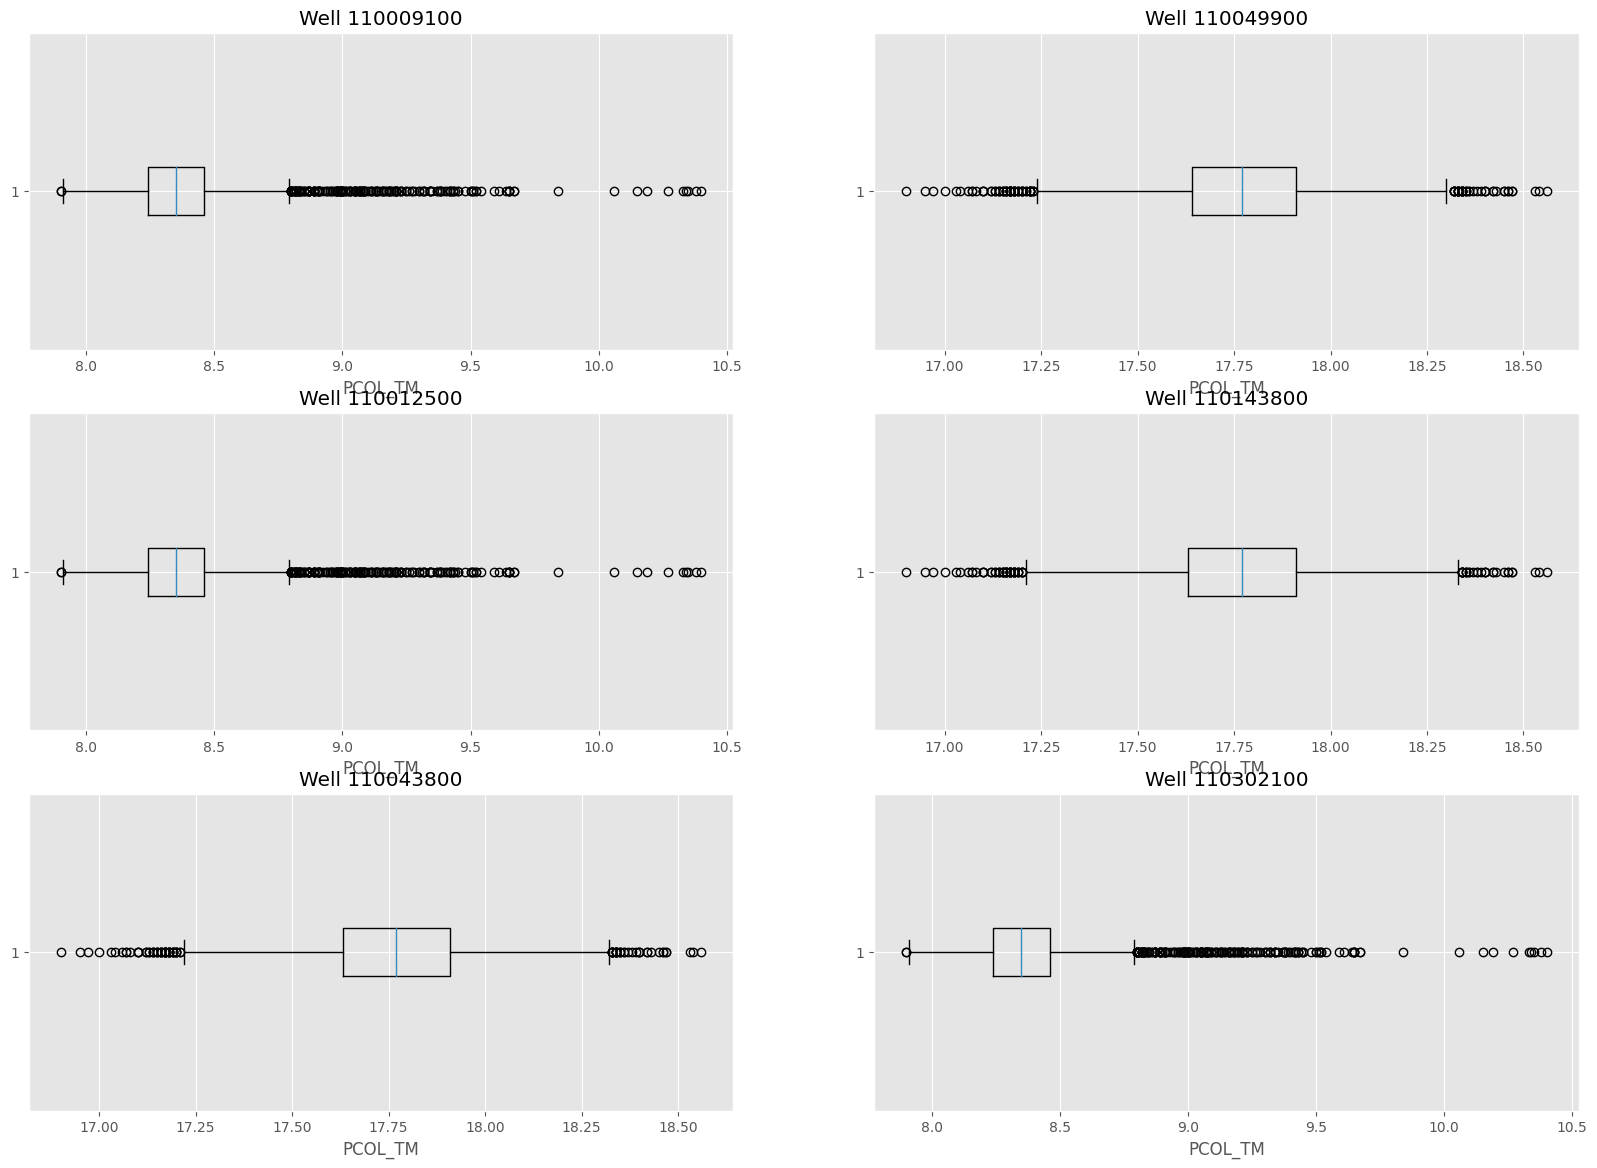

None

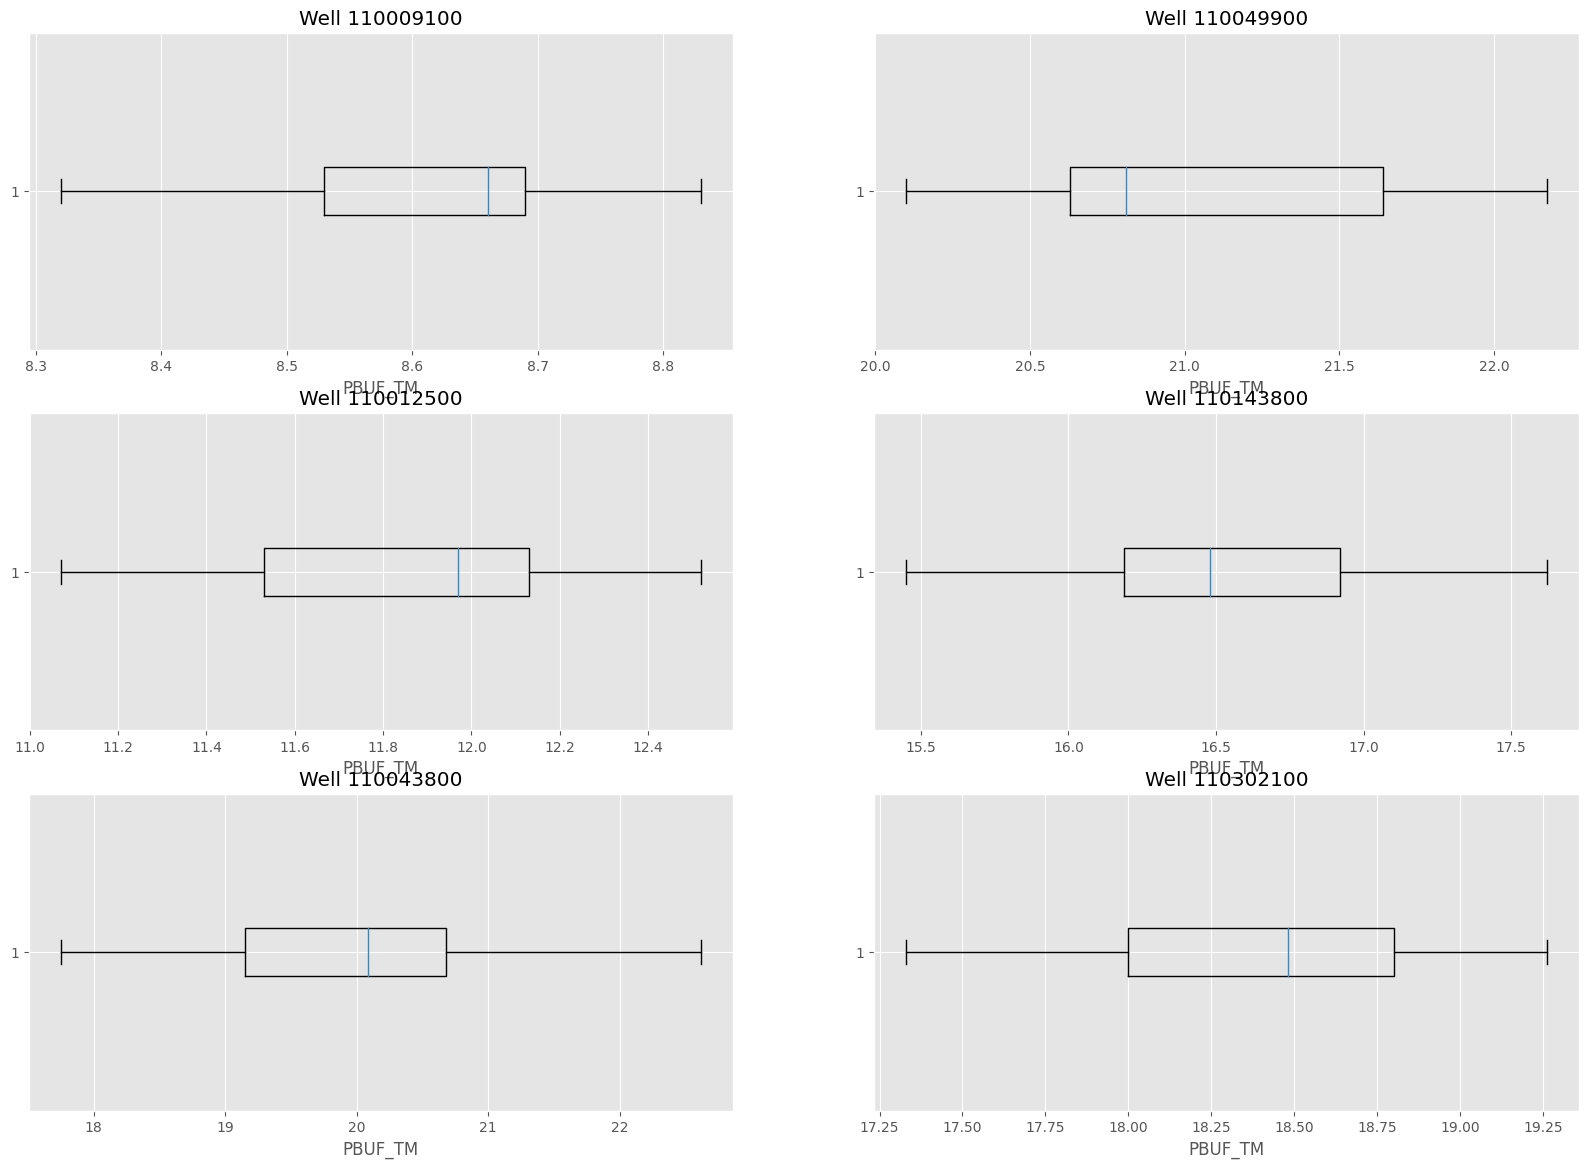

None

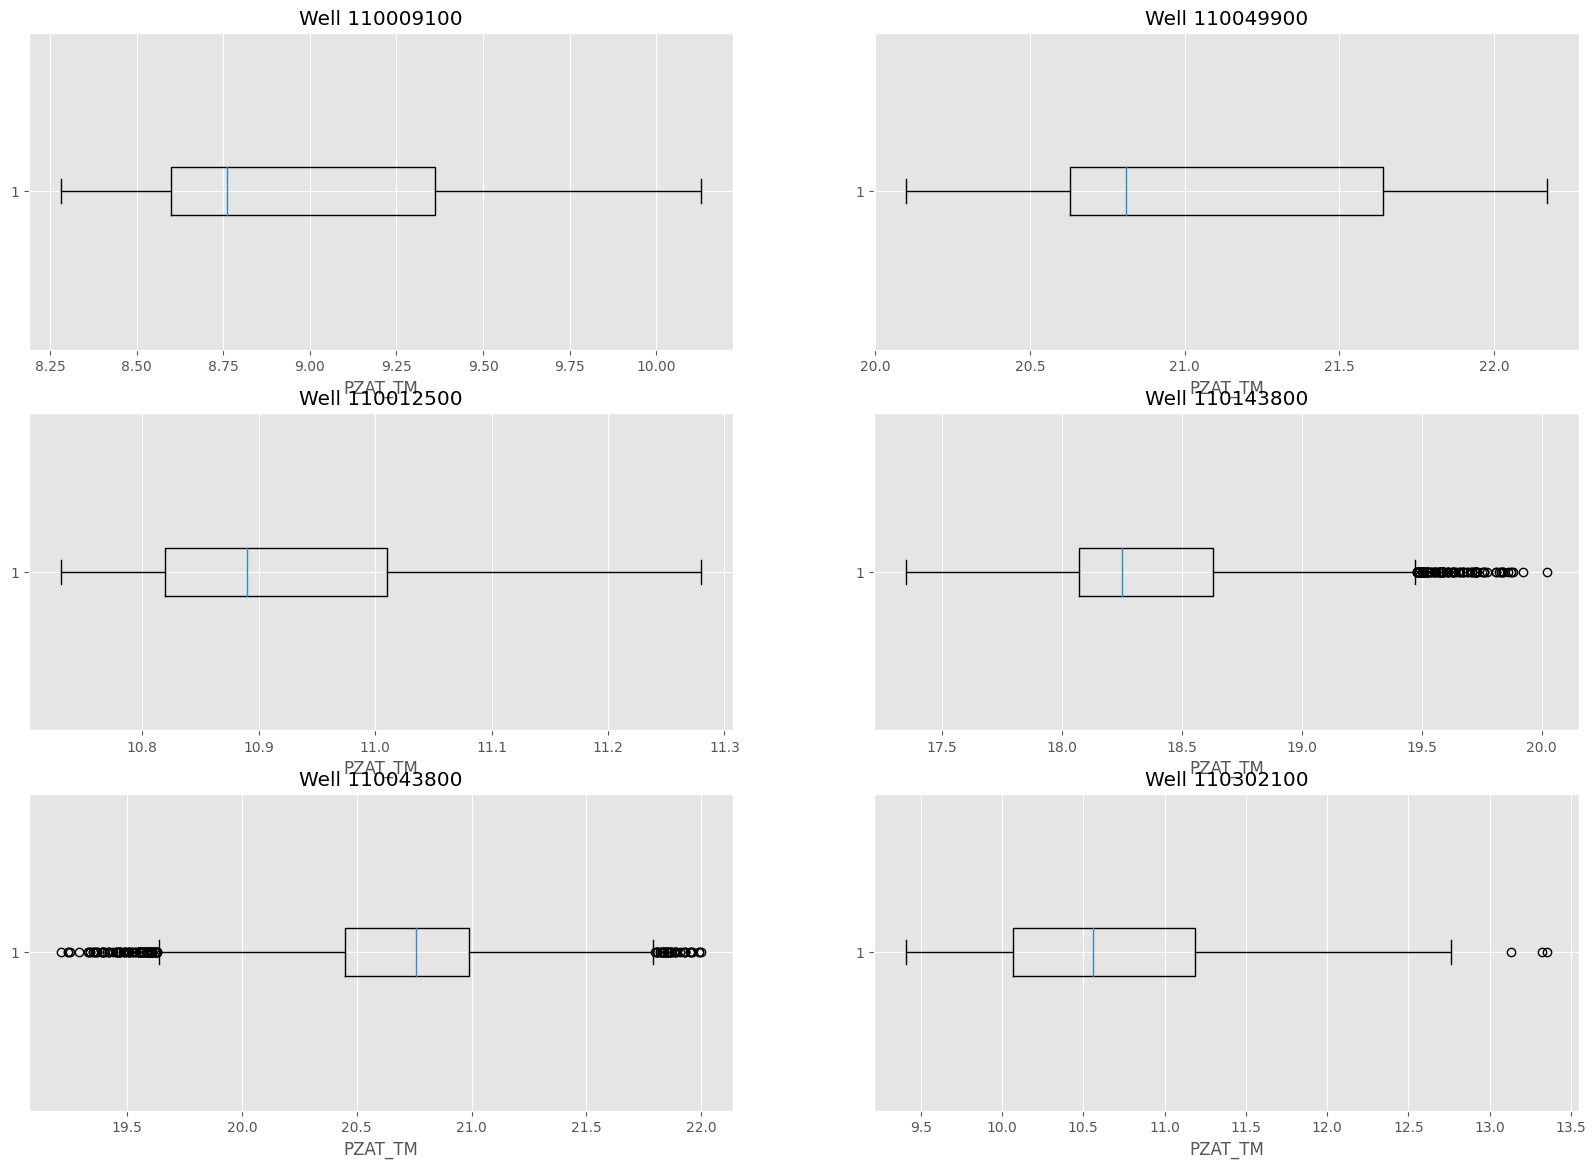

None

In [388]:
for col in df.columns[2:-1]:
    display(
        drow_subplot_wells(
            df = df, 
            columns = ['DATES', col],
            type = 'boxplot',
            figsize = (20, 14)
        )
    )

##### Удаление выбросов (IQR)

In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40394 entries, 0 to 40393
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  40394 non-null  int64  
 1   DATES    40394 non-null  object 
 2   PCOL_TM  40394 non-null  float64
 3   PBUF_TM  40394 non-null  float64
 4   PZAT_TM  40394 non-null  float64
 5   PLIN_TM  19664 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


In [390]:
for well in df.WELL_ID.unique():
    for col in df.columns[2:-1]:        
        q25, q75 = np.percentile(df.loc[df.WELL_ID == well][col], [25, 75])
        IQR = q75 - q25

        max = q75 + (1.5 * IQR)
        min = q25 - (1.5 * IQR)

        df_copy = df[df.WELL_ID == well].copy()
        
        df_copy.loc[df_copy[col] > max] = np.nan
        df_copy.loc[df_copy[col] < min] = np.nan

        df[df.WELL_ID == well] = df_copy.copy()

In [391]:
df = df.dropna(how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39176 entries, 1 to 40393
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  39176 non-null  float64
 1   DATES    39176 non-null  object 
 2   PCOL_TM  39176 non-null  float64
 3   PBUF_TM  39176 non-null  float64
 4   PZAT_TM  39176 non-null  float64
 5   PLIN_TM  19058 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.1+ MB


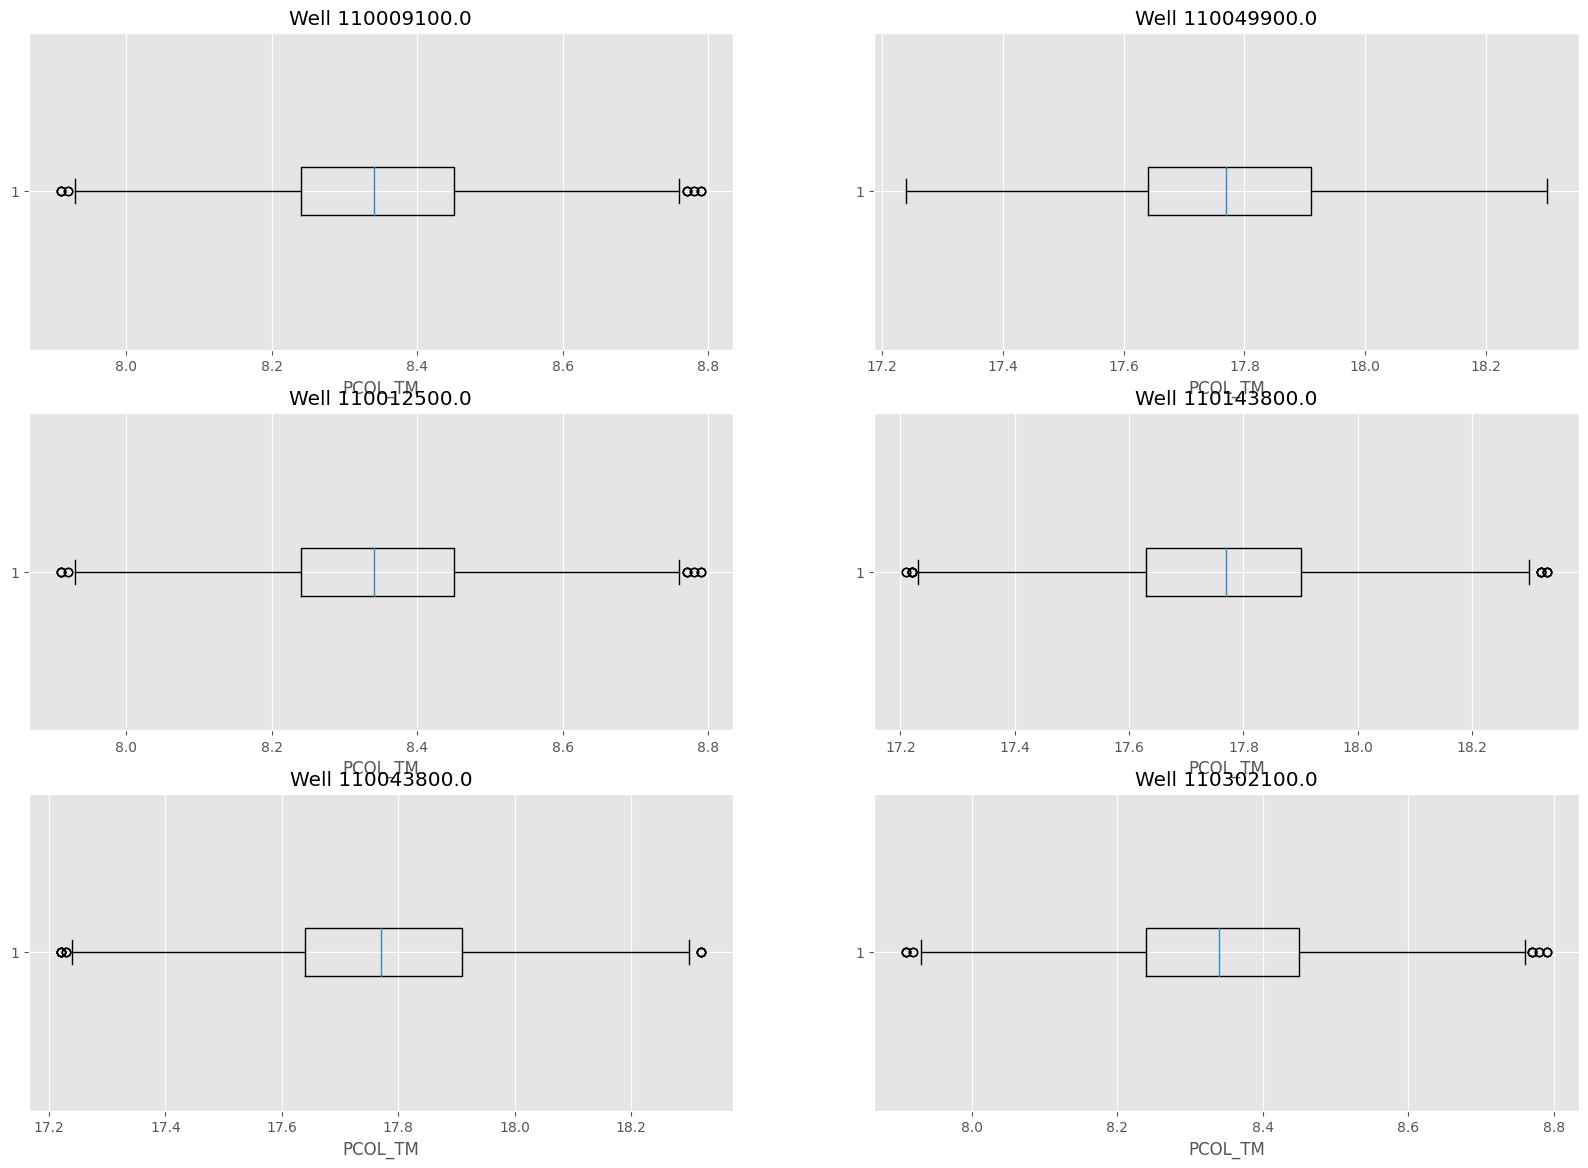

None

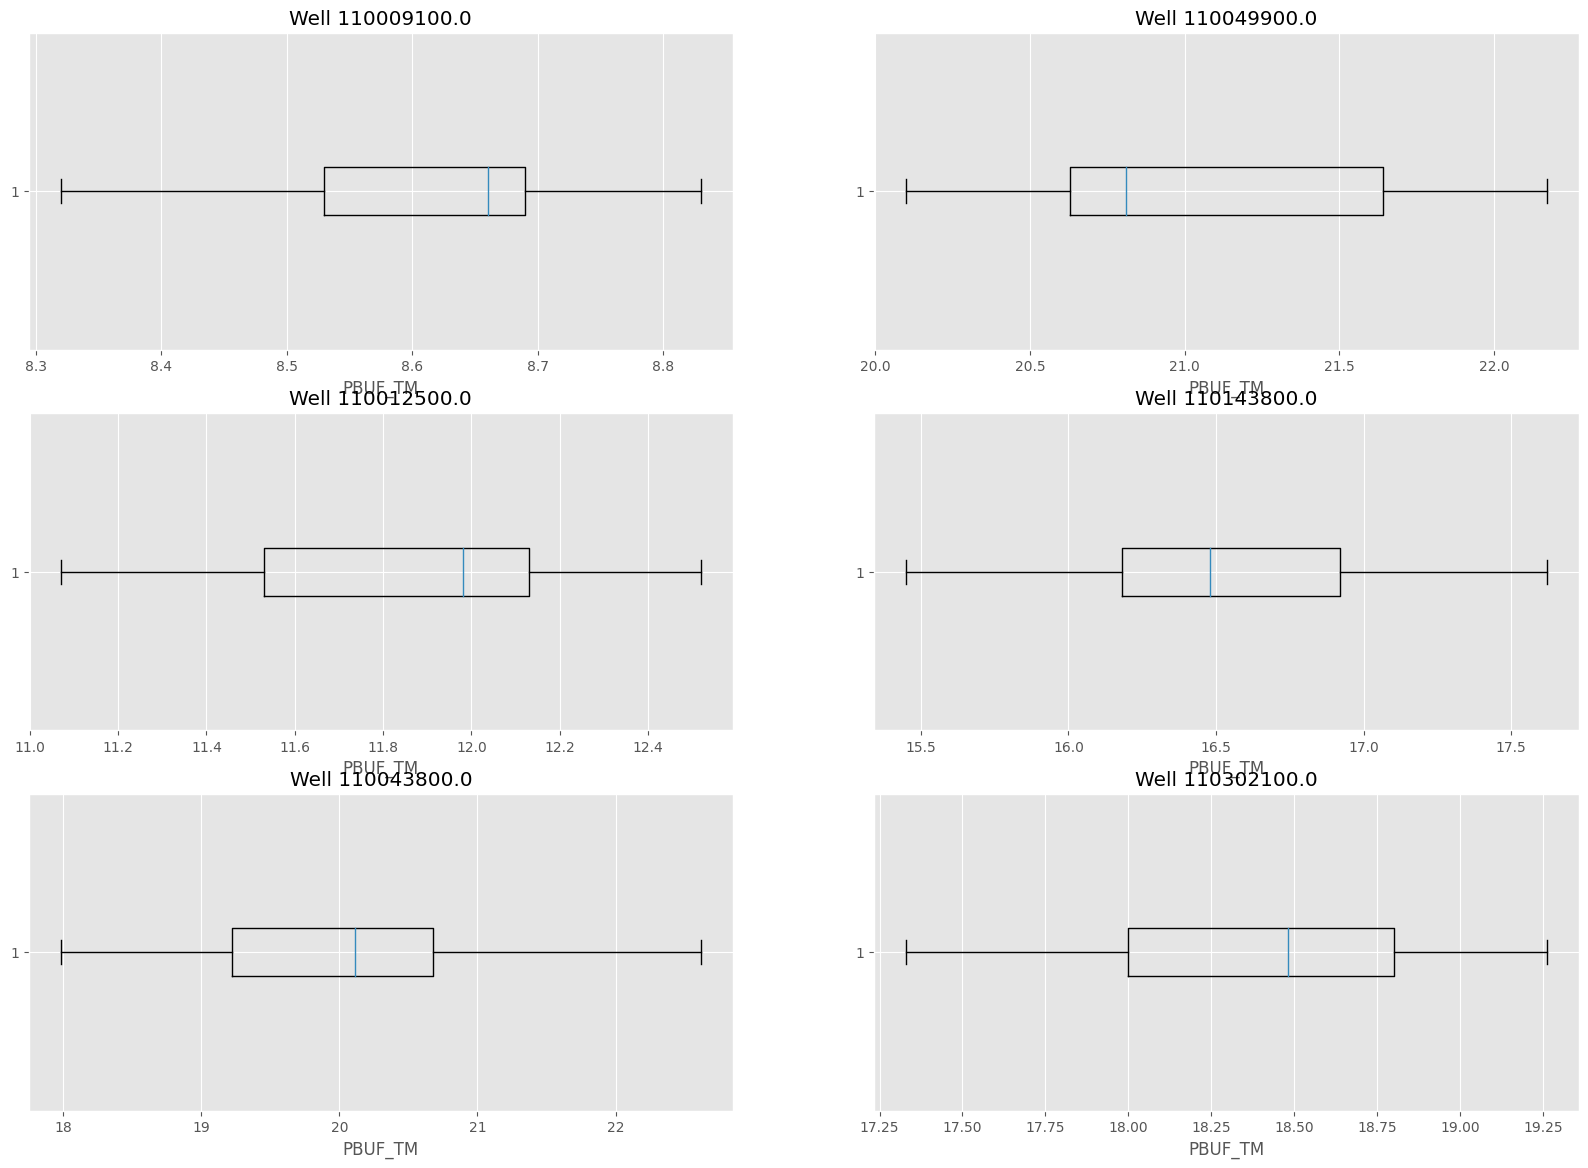

None

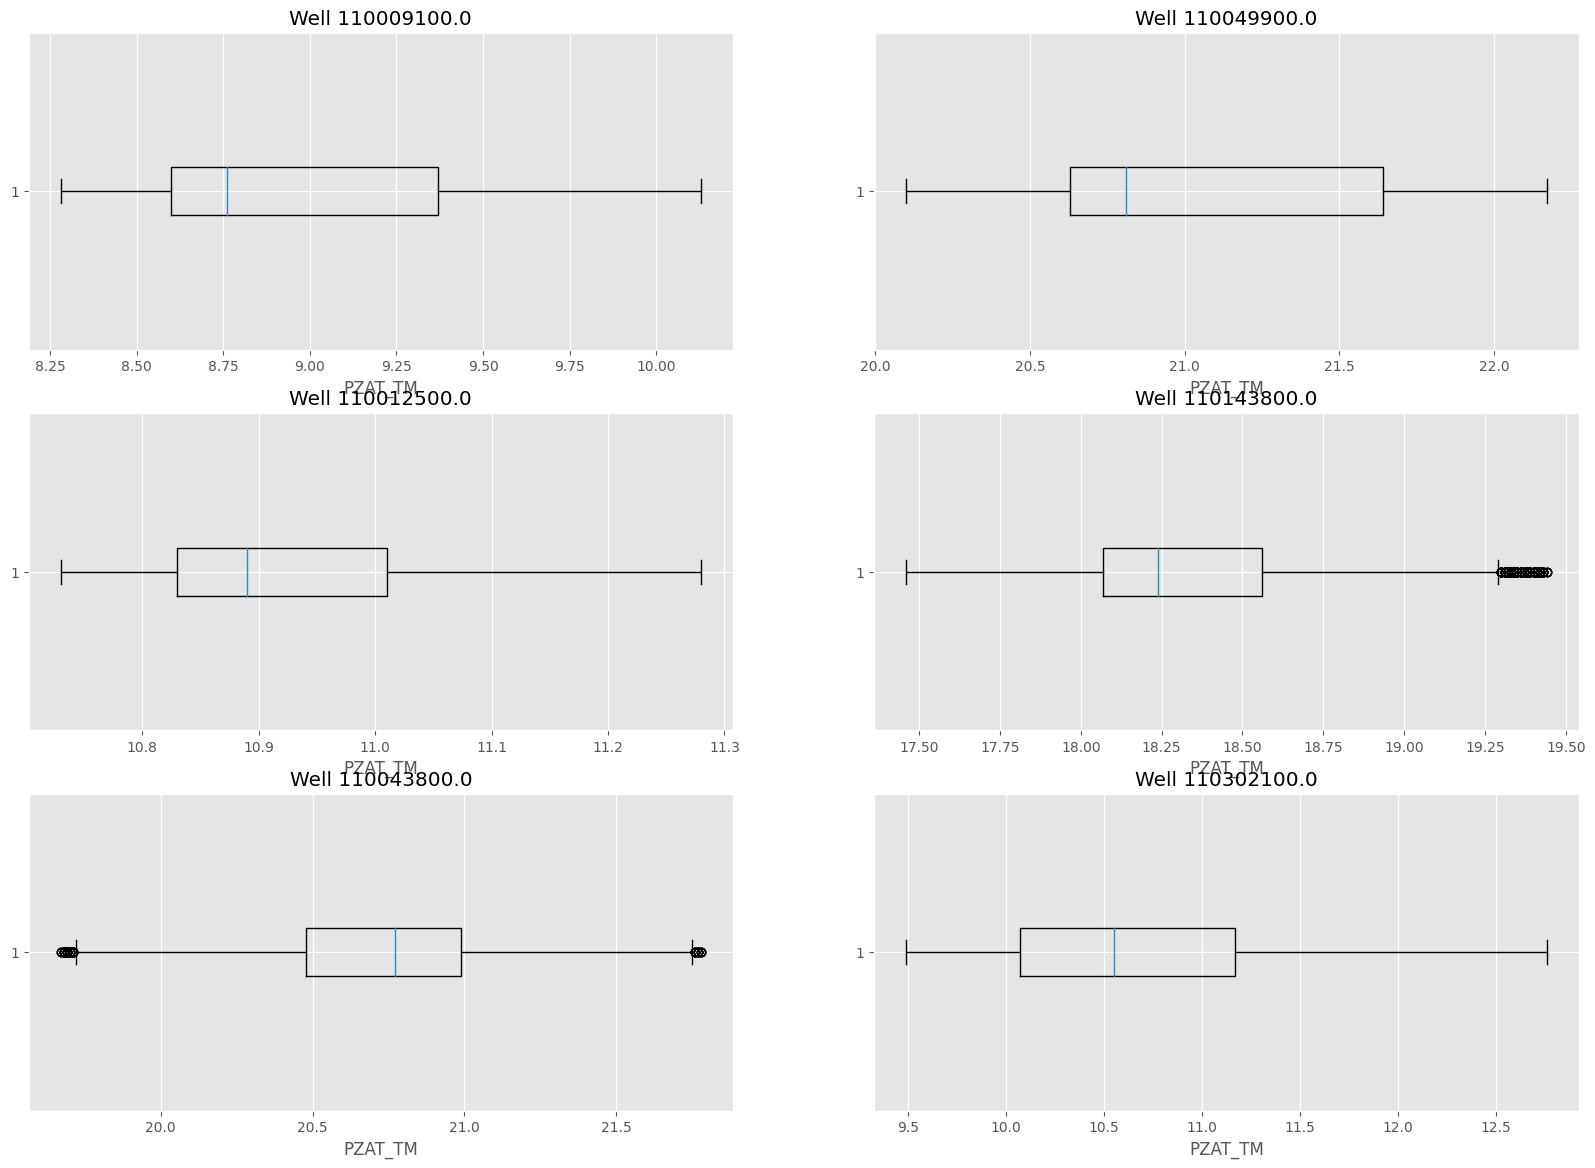

None

In [392]:
for col in df.columns[2:-1]:
    display(
        drow_subplot_wells(
            df = df, 
            columns = ['DATES', col],
            type = 'boxplot',
            figsize = (20, 14)
        )
    )

Судя по графику, часть выбросов остались.
Посмотрим на них на графике plot

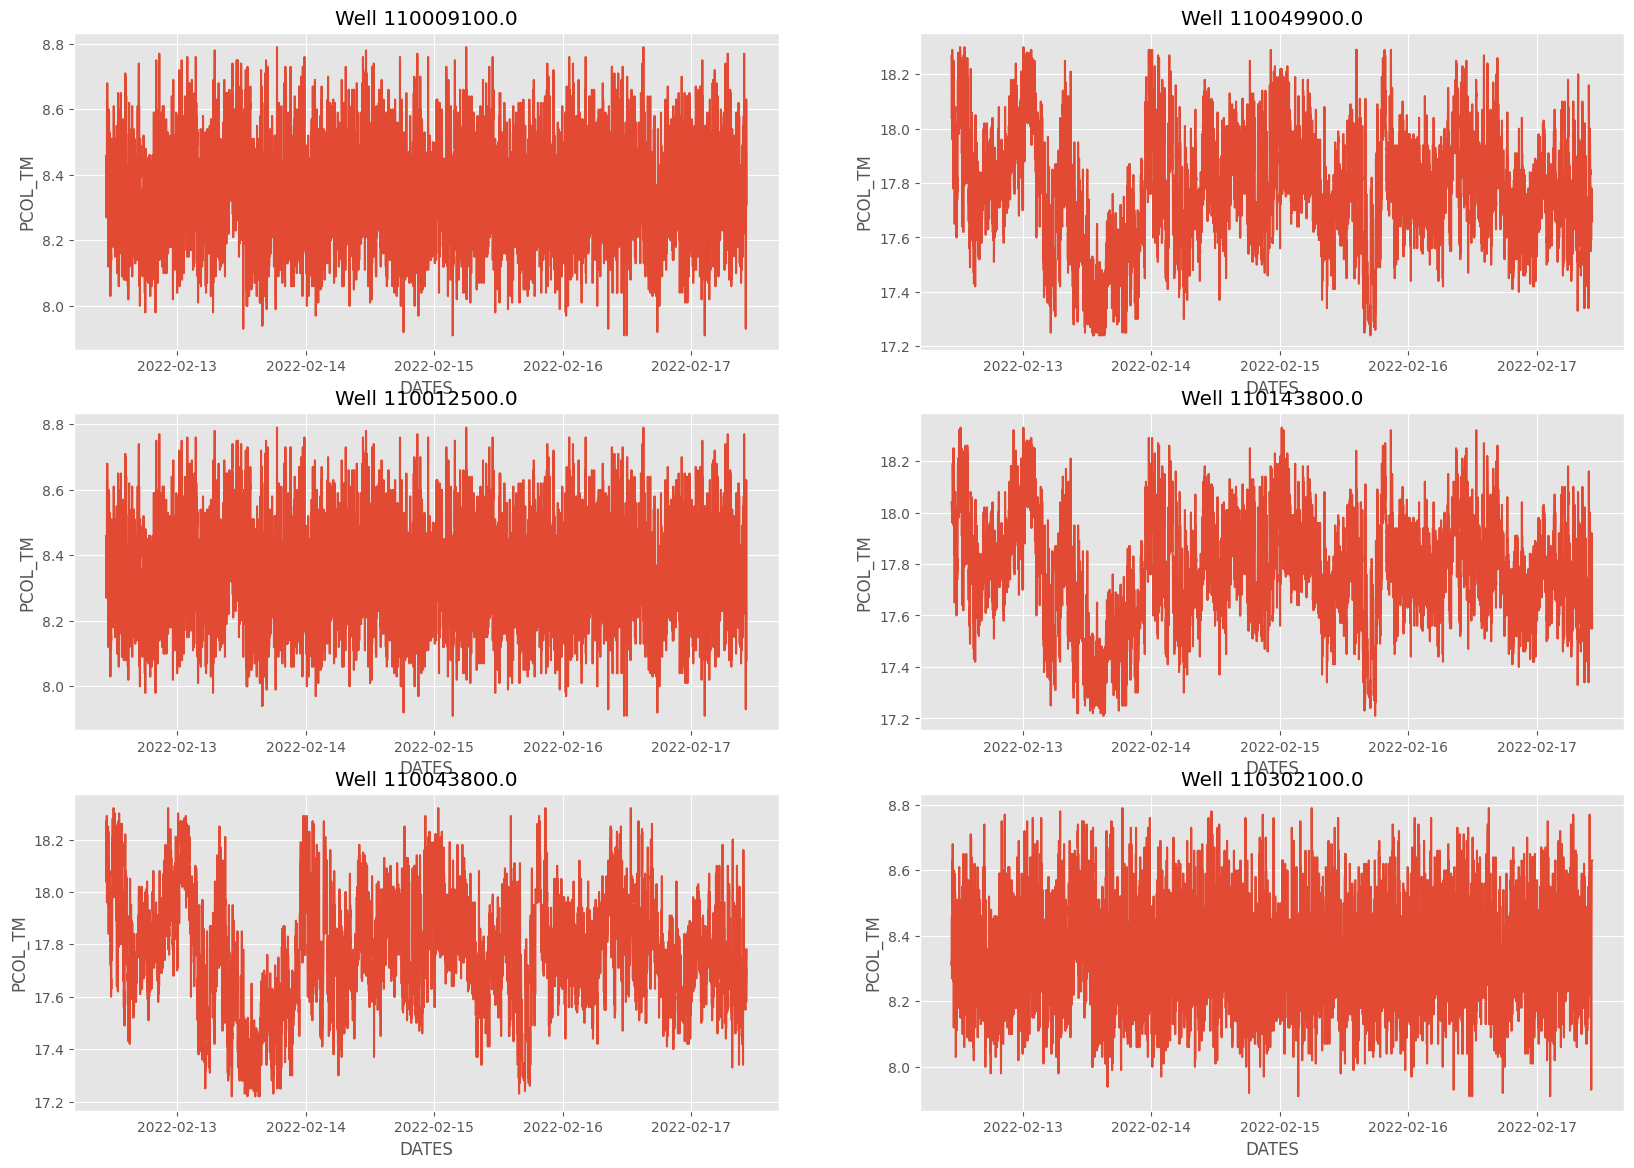

None

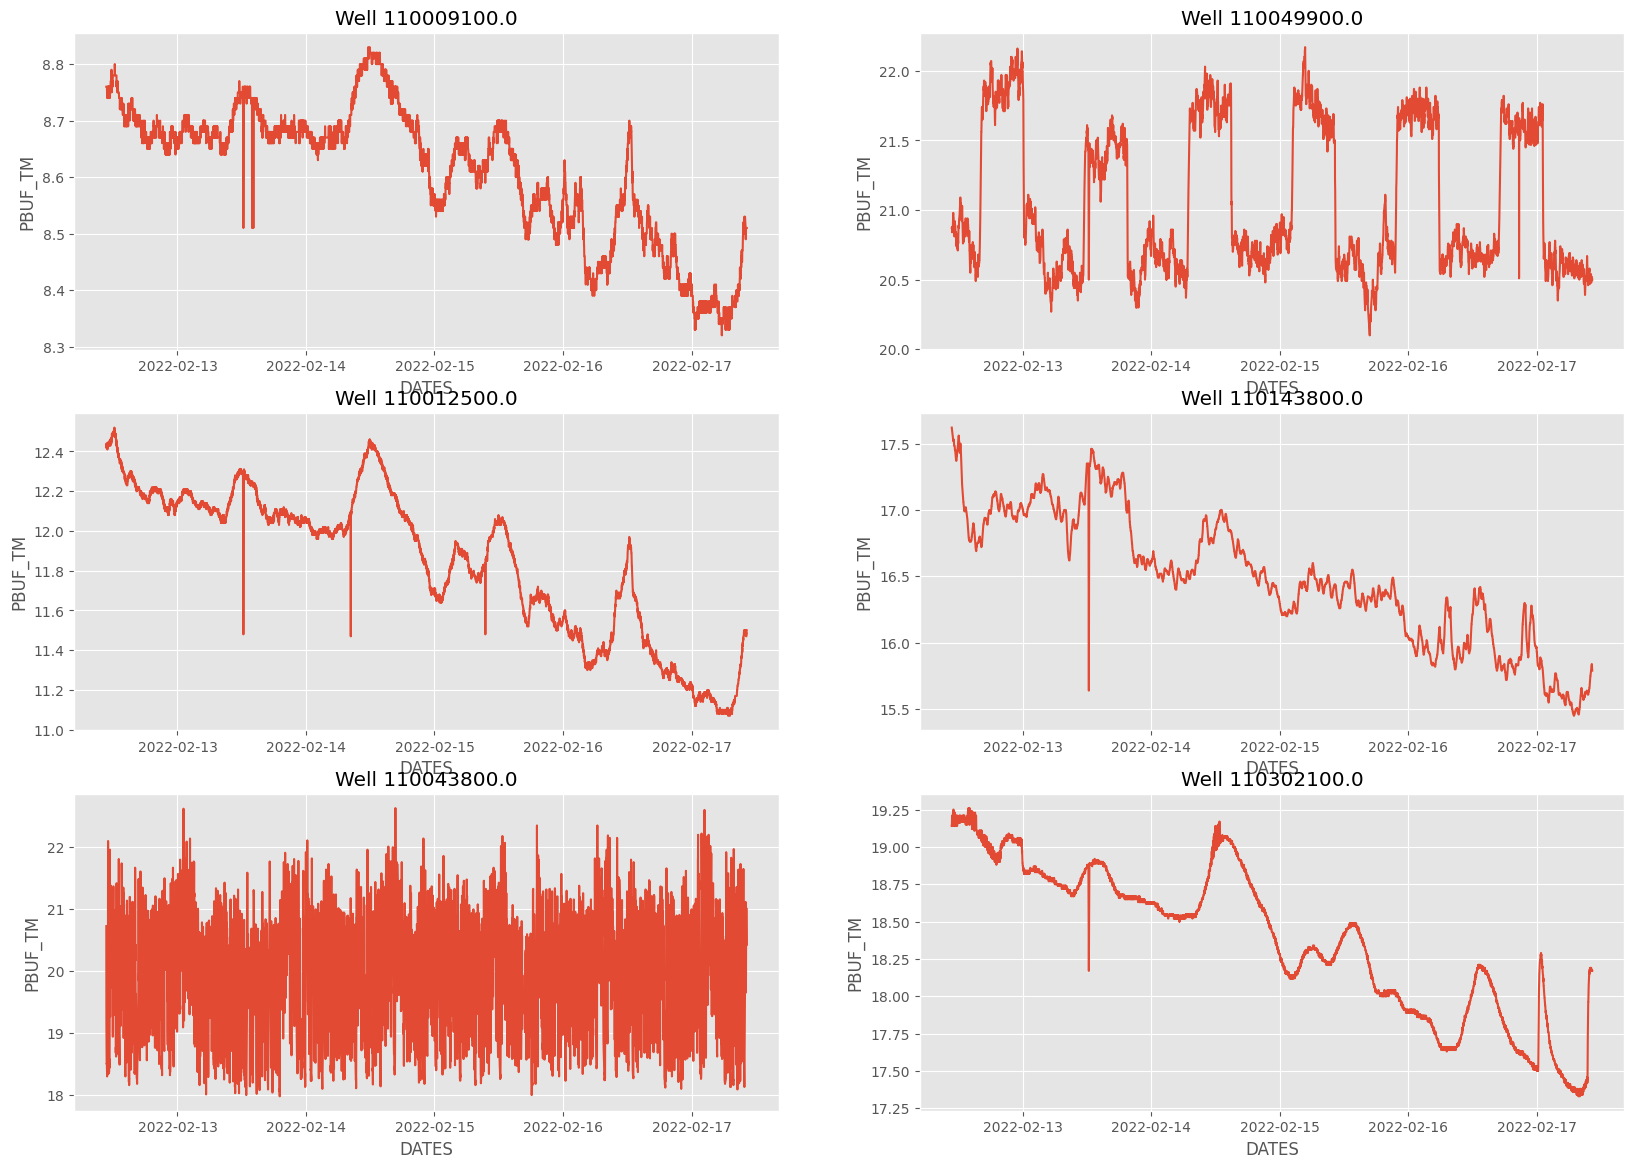

None

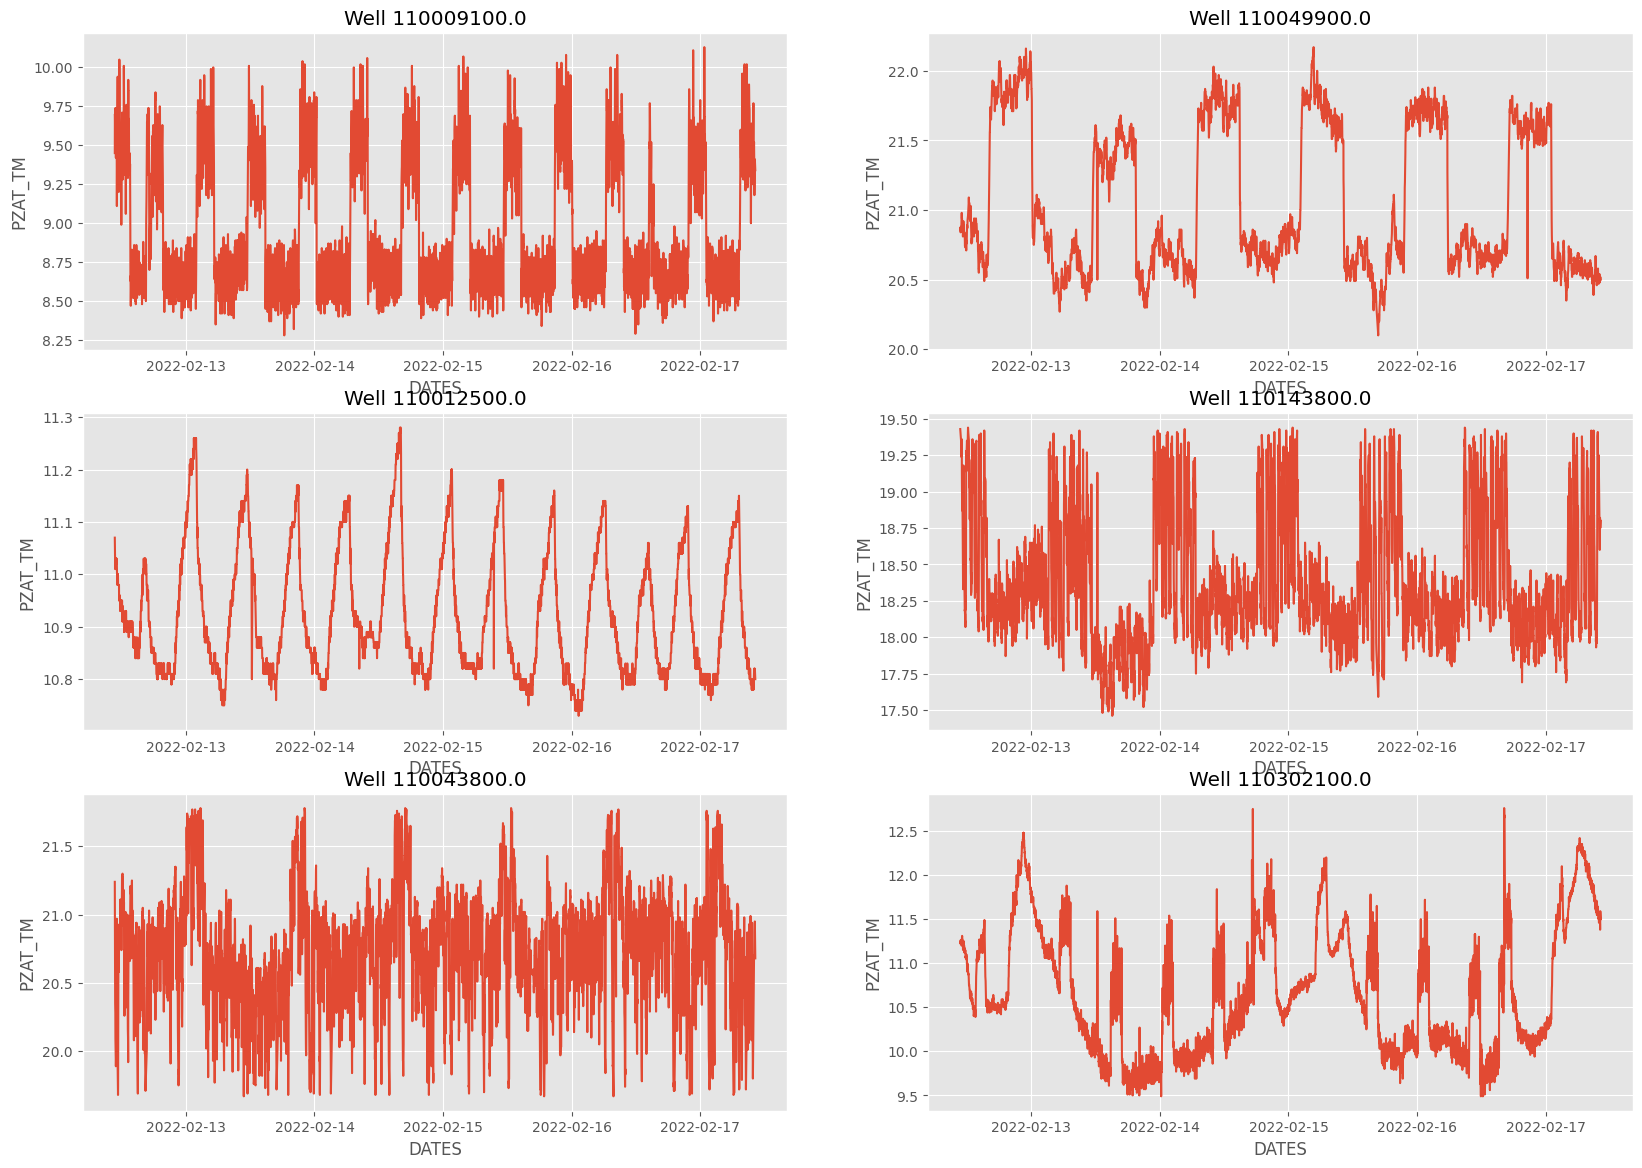

None

In [393]:
for col in df.columns[2:-1]:
    display(
        drow_subplot_wells(
            df = df, 
            columns = ['DATES', col],
            type = 'plot',
            figsize = (20, 14)
        )
    )

На графике серьёзных выбросов не видно

### Аналитика пропусков PLIN_MT по скважинам

In [394]:
for well in df.WELL_ID.unique():
    print(
        well,
        '\nВсего строк:', 
        df.loc[df.WELL_ID == well].shape[0],
        '\nСтрок без пропусков PLIN_TM:', 
        df.loc[
            (df.WELL_ID == well) & 
            (df.PLIN_TM.notna())
        ].shape[0],
        '\nСтрок c пропусками PLIN_TM:', 
        df.loc[
            (df.WELL_ID == well) & 
            (df.PLIN_TM.isnull())
        ].shape[0],
        '\n'
    )

110009100.0 
Всего строк: 6943 
Строк без пропусков PLIN_TM: 341 
Строк c пропусками PLIN_TM: 6602 

110012500.0 
Всего строк: 6942 
Строк без пропусков PLIN_TM: 341 
Строк c пропусками PLIN_TM: 6601 

110043800.0 
Всего строк: 6036 
Строк без пропусков PLIN_TM: 5931 
Строк c пропусками PLIN_TM: 105 

110049900.0 
Всего строк: 6226 
Строк без пропусков PLIN_TM: 6105 
Строк c пропусками PLIN_TM: 121 

110143800.0 
Всего строк: 6089 
Строк без пропусков PLIN_TM: 6000 
Строк c пропусками PLIN_TM: 89 

110302100.0 
Всего строк: 6940 
Строк без пропусков PLIN_TM: 340 
Строк c пропусками PLIN_TM: 6600 



Т.к. у нас более 50% пропусков, мы будем использовать машинное обучение для их заполнения. Строк без пропусков должно хватить для обучения модели, поэтому мы можем отделить данные без пропусков и работать с ними как с датасетом для МО

### Делим датасет

In [395]:
df_full = df[df.PLIN_TM.notna()]
df_null = df[df.PLIN_TM.isnull()]

df_full.shape, df_null.shape

((19058, 6), (20118, 6))

т.к. на PLIN влияет только PCOL, мы можем использовать для обучения модели только его

In [396]:
df_full = df_full[['PCOL_TM', 'PLIN_TM']]
df_full

,PCOL_TM,PLIN_TM
8,8.69,8.29
33,8.33,8.26
53,8.31,8.32
59,8.34,8.30
82,8.64,8.30
...,...,...
40310,8.70,9.11
40317,8.45,8.80
40340,8.14,8.86
40344,8.28,8.81


### Обучение

#### Формируем Train и Test выборки 

In [397]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(columns = ['PLIN_TM']), 
    df_full.PLIN_TM, 
    train_size = 0.5, 
    shuffle = True,
    random_state = 42
)

In [398]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9529, 1), (9529, 1), (9529,), (9529,))

#### Линейная регрессия

In [399]:
params = {}

model_Linear = GridSearchCV(
    estimator = LinearRegression(),
    param_grid = params,
    cv = 10
) 

model_Linear.fit(
    X_train,
    y_train
)

y_pred = model_Linear.best_estimator_.predict(X_test)

In [400]:
mse = MSE(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))
Rsq = R2(y_test, y_pred)

print('MSE',mse)
print('RMSE',rmse)
print('R2',Rsq)

MSE 0.021749212546020125
RMSE 0.147476142294339
R2 0.9947868743421091


#### Случайный лес

In [401]:
params = {
            'n_estimators': [125], # [100, 150, 200]
            'max_depth': [5],      # [1, 5, 10]
            'random_state': [10]   # [10]
}

model_RF = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = params,
    cv = 10
) 

model_RF.fit(
    X_train,
    y_train
)

y_pred = model_RF.best_estimator_.predict(X_test)

In [402]:
mse = MSE(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))
Rsq = R2(y_test, y_pred)

print('Best params:', model_RF.best_params_)
print('MSE',mse)
print('RMSE',rmse)
print('R2',Rsq)

Best params: {'max_depth': 5, 'n_estimators': 125, 'random_state': 10}
MSE 0.021989345904785428
RMSE 0.14828805044502213
R2 0.9947293161490828


#### CatBoostRegressor

In [403]:
params = {
     'depth'         : [5],     # [5, 10, 15]
     'iterations'    : [20],    # [5, 10, 20, 50, 100]
     'learning_rate' : [0.5],   # [0, 0.5, 1]
     'random_state'  : [10]
}

model_CB = GridSearchCV(
    estimator = CatBoostRegressor(),
    param_grid = params,
    cv = 10
) 

model_CB.fit(
    X_train,
    y_train
)

y_pred = model_CB.best_estimator_.predict(X_test)

/home/nel/.local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.0488792	total: 11.4ms	remaining: 217ms
1:	learn: 0.5558601	total: 17.7ms	remaining: 159ms
2:	learn: 0.3165832	total: 24ms	remaining: 136ms
3:	learn: 0.2150208	total: 29.7ms	remaining: 119ms
4:	learn: 0.1773343	total: 35.1ms	remaining: 105ms
5:	learn: 0.1661429	total: 40.2ms	remaining: 93.9ms
6:	learn: 0.1619546	total: 46.1ms	remaining: 85.6ms
7:	learn: 0.1574817	total: 51.5ms	remaining: 77.3ms
8:	learn: 0.1564549	total: 56.4ms	remaining: 68.9ms
9:	learn: 0.1561252	total: 62.4ms	remaining: 62.4ms
10:	learn: 0.1557819	total: 67.2ms	remaining: 55ms
11:	learn: 0.1556083	total: 72.3ms	remaining: 48.2ms
12:	learn: 0.1549932	total: 78ms	remaining: 42ms
13:	learn: 0.1548954	total: 83.2ms	remaining: 35.7ms
14:	learn: 0.1546083	total: 88.6ms	remaining: 29.5ms
15:	learn: 0.1541721	total: 95.2ms	remaining: 23.8ms
16:	learn: 0.1541126	total: 101ms	remaining: 17.8ms
17:	learn: 0.1539564	total: 106ms	remaining: 11.8ms
18:	learn: 0.1538195	total: 112ms	remaining: 5.88ms
19:	learn: 0.153650

In [404]:
mse = MSE(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))
Rsq = R2(y_test, y_pred)

print('Best params:', model_CB.best_params_)
print('MSE',mse)
print('RMSE',rmse)
print('R2',Rsq)

Best params: {'depth': 5, 'iterations': 20, 'learning_rate': 0.5, 'random_state': 10}
MSE 0.02189239330063644
RMSE 0.147960782981966
R2 0.9947525549724295


#### Стакинг

In [405]:
base_estimators = [
    ('RF', model_RF.best_estimator_),
    ('Linear', model_Linear.best_estimator_),
    ('CB', model_CB.best_estimator_),
]

model_stack = StackingRegressor(
    estimators=base_estimators, 
    final_estimator=LinearRegression(), 
    cv=10,
)

model_stack.fit(X_train, y_train)

y_pred = model_stack.predict(X_test)

/home/nel/.local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.0395764	total: 6.51ms	remaining: 124ms
1:	learn: 0.5497923	total: 11.6ms	remaining: 104ms
2:	learn: 0.3135287	total: 16.7ms	remaining: 94.6ms
3:	learn: 0.2136971	total: 22.7ms	remaining: 90.9ms
4:	learn: 0.1772640	total: 27.2ms	remaining: 81.6ms
5:	learn: 0.1662934	total: 32.2ms	remaining: 75.2ms
6:	learn: 0.1624164	total: 37.5ms	remaining: 69.6ms
7:	learn: 0.1583327	total: 42.4ms	remaining: 63.6ms
8:	learn: 0.1559362	total: 47.6ms	remaining: 58.2ms
9:	learn: 0.1554492	total: 53.7ms	remaining: 53.7ms
10:	learn: 0.1545506	total: 59.1ms	remaining: 48.4ms
11:	learn: 0.1543955	total: 64.7ms	remaining: 43.2ms
12:	learn: 0.1540495	total: 70ms	remaining: 37.7ms
13:	learn: 0.1533281	total: 75.4ms	remaining: 32.3ms
14:	learn: 0.1530451	total: 82.9ms	remaining: 27.6ms
15:	learn: 0.1523471	total: 88.2ms	remaining: 22ms
16:	learn: 0.1522771	total: 93.6ms	remaining: 16.5ms
17:	learn: 0.1518465	total: 99.2ms	remaining: 11ms
18:	learn: 0.1515287	total: 104ms	remaining: 5.46ms
19:	learn: 0

/home/nel/.local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 1.0488792	total: 5.26ms	remaining: 99.9ms
1:	learn: 0.5558601	total: 11.5ms	remaining: 104ms
2:	learn: 0.3165832	total: 16.6ms	remaining: 94.3ms
3:	learn: 0.2150208	total: 21.4ms	remaining: 85.7ms
4:	learn: 0.1773343	total: 26.9ms	remaining: 80.8ms
5:	learn: 0.1661429	total: 31.9ms	remaining: 74.4ms
6:	learn: 0.1619546	total: 36.7ms	remaining: 68.1ms
7:	learn: 0.1574817	total: 42.8ms	remaining: 64.2ms
8:	learn: 0.1564549	total: 47.6ms	remaining: 58.2ms
9:	learn: 0.1561252	total: 52.8ms	remaining: 52.8ms
10:	learn: 0.1557819	total: 58.3ms	remaining: 47.7ms
11:	learn: 0.1556083	total: 62.7ms	remaining: 41.8ms
12:	learn: 0.1549932	total: 67.6ms	remaining: 36.4ms
13:	learn: 0.1548954	total: 72.6ms	remaining: 31.1ms
14:	learn: 0.1546083	total: 77.4ms	remaining: 25.8ms
15:	learn: 0.1541721	total: 83ms	remaining: 20.8ms
16:	learn: 0.1541126	total: 87.8ms	remaining: 15.5ms
17:	learn: 0.1539564	total: 93.3ms	remaining: 10.4ms
18:	learn: 0.1538195	total: 98.4ms	remaining: 5.18ms
19:	le

/home/nel/.local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [406]:
mse = MSE(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))
Rsq = R2(y_test, y_pred)

print('MSE',mse)
print('RMSE',rmse)
print('R2',Rsq)

MSE 0.021625461268147426
RMSE 0.14705598004891685
R2 0.9948165366096744


### Результат обучения

In [407]:
print('MSE',mse)
print('RMSE',rmse)
print('R2',Rsq)

MSE 0.021625461268147426
RMSE 0.14705598004891685
R2 0.9948165366096744


Мы получили хорошую модель для предсказания. Теперь нам надо предсказать пропущенные значения для колонки PLIN_TM

### Предсказываем недостающие значения

In [408]:
PLIN_TM = model_stack.predict(df_null.iloc[:, [2]])

/home/nel/.local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [409]:
PLIN_TM

array([8.88248543, 8.82141868, 8.84127424, ..., 8.74764698, 8.74198775,
       8.74764698])

### Добавляем предсказанные значения в общий датасет

In [410]:
df_null['PLIN_TM'] = PLIN_TM
df_null['PLIN_TM'] = df_null['PLIN_TM'].round(2)

/tmp/ipykernel_19516/4266583844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null['PLIN_TM'] = PLIN_TM
/tmp/ipykernel_19516/4266583844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null['PLIN_TM'] = df_null['PLIN_TM'].round(2)


In [411]:
df_null

,WELL_ID,DATES,PCOL_TM,PBUF_TM,PZAT_TM,PLIN_TM
1,110009100.0,17.2.2022 2:44:00,8.43,8.38,8.74,8.88
2,110009100.0,17.2.2022 2:50:00,8.32,8.36,8.53,8.82
3,110009100.0,17.2.2022 2:55:00,8.34,8.38,8.56,8.84
4,110009100.0,17.2.2022 3:36:59,8.39,8.38,8.67,8.89
5,110009100.0,17.2.2022 3:54:59,8.31,8.37,8.60,8.81
...,...,...,...,...,...,...
40389,110302100.0,12.2.2022 17:32:00,8.21,18.96,10.48,8.74
40390,110302100.0,12.2.2022 17:42:00,8.52,18.96,10.48,8.98
40391,110302100.0,12.2.2022 18:06:59,8.24,18.95,10.45,8.75
40392,110302100.0,12.2.2022 18:08:59,8.22,18.97,10.47,8.74


In [412]:
df[df.PLIN_TM.isnull()] = df_null

/tmp/ipykernel_19516/3669497696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.PLIN_TM.isnull()] = df_null


## Итог

In [413]:
df

,WELL_ID,DATES,PCOL_TM,PBUF_TM,PZAT_TM,PLIN_TM
1,110009100.0,17.2.2022 2:44:00,8.43,8.38,8.74,8.88
2,110009100.0,17.2.2022 2:50:00,8.32,8.36,8.53,8.82
3,110009100.0,17.2.2022 2:55:00,8.34,8.38,8.56,8.84
4,110009100.0,17.2.2022 3:36:59,8.39,8.38,8.67,8.89
5,110009100.0,17.2.2022 3:54:59,8.31,8.37,8.60,8.81
...,...,...,...,...,...,...
40389,110302100.0,12.2.2022 17:32:00,8.21,18.96,10.48,8.74
40390,110302100.0,12.2.2022 17:42:00,8.52,18.96,10.48,8.98
40391,110302100.0,12.2.2022 18:06:59,8.24,18.95,10.45,8.75
40392,110302100.0,12.2.2022 18:08:59,8.22,18.97,10.47,8.74


In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39176 entries, 1 to 40393
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WELL_ID  39176 non-null  float64
 1   DATES    39176 non-null  object 
 2   PCOL_TM  39176 non-null  float64
 3   PBUF_TM  39176 non-null  float64
 4   PZAT_TM  39176 non-null  float64
 5   PLIN_TM  39176 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.1+ MB


In [415]:
df.to_csv('./result.csv', sep=',')